In [1]:
import os, sys
import pyspark
from pyspark.sql import SQLContext

from pyspark.sql import SparkSession # to create dataframes

sc = pyspark.SparkContext.getOrCreate()
#sqlContext = SQLContext(sc)
sqlContext = SparkSession.builder.appName("test").enableHiveSupport().getOrCreate()

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import pyspark.sql.functions as F # to work with dataframes siimilar to rdd.map()
from pyspark.sql.functions import lit # to fill new column with custom values
from pyspark.sql.functions import col # to select a dataframe column

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# to read parquet file
#df1 = sqlContext.read.parquet('data/FireDepartmentSample.parquet')
df1 = sqlContext.read.parquet('/home/shashank/Documents/gitWorkspace/SFFD-Spark-Project/Data/FireDepartmentSample.parquet')
df1 = df1.repartition(8)
df1.rdd.getNumPartitions()

8

# Data description:


## Column Name  |  Description  |  Data Type

Call Number  |  A unique 9-digit number assigned by the 911 Dispatch Center (DEM) to this call. These number are used for both Police and Fire calls.  |  Plain Text

Unit ID  |  A unique code assigned for every unit  |  Plain Text

Incident Number  |  A unique 8-digit number assigned by DEM to this Fire incident.  |  Plain Text

Call Type  |  Call Type  |  Plain Text

Call Date  |  Date the call is received at the 911 Dispatch Center. Used for reporting purposes.  |  Date & Time

Watch Date  |  Watch date when the call is received. Watch date starts at 0800 each morning and ends at 0800 the next day.  |  Date & Time

Received DtTm  |  Date and time of call is received at the 911 Dispatch Center.  |  Date & Time

Entry DtTm  |  Date and time the 911 operator submits the entry of the initical call information into the CAD system  |  Date & Time

Dispatch DtTm  |  Date and time the 911 operator dispatches this unit to the call.  |  Date & Time

Response DtTm  |  Date and time this unit acknowledges the dispatch and records that the unit is en route to the location of the call.  |  Date & Time

On Scene DtTm  |  Date and time the unit records arriving to the location of the incident  |  Date & Time

Transport DtTm  |  If this unit is an ambulance, date and time the unit begins the transport unit arrives to hospital  |  Date & Time

Hospital DtTm  |  If this unit is an ambulance, date and time the unit arrives to the hospital.  |  Date & Time

Call Final Disposition  |  Disposition of the call (Code). For example TH2: Transport to Hospital - Code 2, FIR: Resolved by Fire Department  |  Plain Text

Available DtTm  |  \Date and time this unit is not longer assigned to this call and it is available for another dispatch.  |  Date & Time

Address  |  Address of incident (note: address and location generalized to mid-block of street, intersection or nearest call box location, to protect caller privacy).  |  Plain Text

City  |  City of incident  |  Plain Text

Zipcode of Incident  |  Zipcode of incident  |  Plain Text

Battalion  |  Emergency Response District (There are 9 Fire Emergency Response Districts)  |  Plain Text

Station Area  |  Fire Station First Response Area associated with the address of the incident  |  Plain Text

Box  |  Fire box associated with the address of the incident. A box is the smallest area used to divide the City. Each box is associated with a unique unit dispatch order. The City is divided into more than 2,400 boxes.  |  Plain Text

Original Priority  |  Initial call priority (Code 2: Non-Emergency or Code 3:Emergency).  |  Plain Text

Priority  |  Call priority (Code 2: Non-Emergency or Code 3:Emergency).  |  Plain Text

Final Priority  |  Final call priority (Code 2: Non-Emergency or Code 3:Emergency).  |  Plain Text

ALS Unit  |  Does this unit includes ALS (Advance Life Support) resources? Is there a paramedic in this unit?  |  Checkbox

Call Type Group  |  Call types are divided into four main groups: Fire, Alarm, Potential Life Threatening and Non Life Threatening.  |  Plain Text

Number of Alarms  |  Number of alarms associated with the incident. This is a number between 1 and 5.  |  Number

Unit Type  |  Unit type  |  Plain Text

Unit sequence in call dispatch  |  A number that indicates the order this unit was assigned to this call  |  Number

Fire Prevention District  |  Bureau of Fire Prevention District associated with this address  |  Plain Text

Supervisor District  |  Supervisor District associated with this address (note: these are the districts created in 2012).  |  Plain Text

Neighborhooods - Analysis Boundaries  |  Neighborhood District associated with this address  |  Plain Text

Location  |  Location of incident (note: address and location generalized to mid-block of street, intersection or nearest call box location, to protect caller privacy).  |  Location

RowID  |  Unique Call Number and Unit ID combination  |  Plain Text


## Aim is to predict how long it takes for the SFFD to reach the location of incident from moment call is made to 911.
#### Drop the following because we are interested in prediction of : (On_Scene_DtTm - Received_DtTm)

    -Call_Date
    -Watch_Date
    -Entry_DtTm
    -Dispatch_DtTm
    -Response_DtTm
    -Transport_DtTm
    -Hospital_DtTm
    
#### Drop City because we are looking only at one city, San Franscio
#### Drop Call Final Disposition, Priority and Final Priority because these are not known at the time of dispatch hence, theres is no causal relation with response time
#### Drop ALS Unit since this is the decision of SFFD so, can't be used prediction of response time.
#### Drop Unit_sequence_in_call_dispatch since this is a random occurance?
#### Drop Battalion since there is no way of knowing this.
#### Drop Address since we already have zip, box and coordinates to locate the incident.
#### Drop Neighborhooods_-_Analysis_Boundaries since a single location can have multiple neighborhoods and Supervisor District is already good indicator of the travelling distance.

In [3]:
print("distinct call number =", df1.select('Call_Number').distinct().count())
print("distinct incident number = ", df1.select('Incident_Number').distinct().count())

('distinct call number =', 35124)
('distinct incident number = ', 35124)


#### Since both Call_Number and Incident_Number represent the same event, we can drop Call_Number

In [4]:
df1 = df1.drop('Call_Date', 'Watch_Date', 'Entry_DtTm', 'Dispatch_DtTm',\
               'Response_DtTm', 'Transport_DtTm', 'Hospital_DtTm', \
               'City', 'Priority', 'Final_Priority', 'ALS_Unit', 'Address',  \
               'Unit_sequence_in_call_dispatch', 'Neighborhooods_-_Analysis_Boundaries', \
               'Battalion', 'Call_Number', 'Call_Final_Disposition', '__index_level_0__', 
              )

In [5]:
df1.printSchema()

root
 |-- Unit_ID: string (nullable = true)
 |-- Incident_Number: long (nullable = true)
 |-- Call_Type: string (nullable = true)
 |-- Received_DtTm: string (nullable = true)
 |-- On_Scene_DtTm: string (nullable = true)
 |-- Available_DtTm: string (nullable = true)
 |-- Zipcode_of_Incident: double (nullable = true)
 |-- Station_Area: double (nullable = true)
 |-- Box: double (nullable = true)
 |-- Original_Priority: string (nullable = true)
 |-- Call_Type_Group: string (nullable = true)
 |-- Number_of_Alarms: long (nullable = true)
 |-- Unit_Type: string (nullable = true)
 |-- Fire_Prevention_District: string (nullable = true)
 |-- Supervisor_District: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- RowID: string (nullable = true)



In [6]:
# change format of dates from string to datetime/ date

# Received_DtTm
df1 = df1.withColumn('Received_DtTm', F.to_timestamp('Received_DtTm', 'MM/dd/yyyy HH:mm'))
# On_Scene_DtTm
df1 = df1.withColumn('On_Scene_DtTm', F.to_timestamp('On_Scene_DtTm', 'MM/dd/yyyy HH:mm'))
# Available_DtTm
df1 = df1.withColumn('Available_DtTm', F.to_timestamp('Available_DtTm', 'MM/dd/yyyy HH:mm'))

# month of the year when call was received
df1 = df1.withColumn('Received_month', F.month('Received_DtTm'))

# Hour of the day when call was received
df1 = df1.withColumn('Received_Hour', F.hour('Received_DtTm'))

# response_time = On_Scene_DtTm - Received_DtTm
df1 = df1.withColumn('response_time', (F.unix_timestamp('On_Scene_DtTm') - F.unix_timestamp('Received_DtTm'))/60)

df1.limit(5).toPandas()

,Unit_ID,Incident_Number,Call_Type,Received_DtTm,On_Scene_DtTm,Available_DtTm,Zipcode_of_Incident,Station_Area,Box,Original_Priority,Call_Type_Group,Number_of_Alarms,Unit_Type,Fire_Prevention_District,Supervisor_District,Location,RowID,Received_month,Received_Hour,response_time
0,76,19001062,Medical Incident,2019-01-03 12:03:00,2019-01-03 12:08:00,2019-01-03 13:15:00,94109.0,3.0,1557.0,3,Potentially Life-Threatening,1,MEDIC,4,3,"(37.788126303439334, -122.41765721404082)",190031501-76,1,12,5.0
1,KM12,18130188,Medical Incident,2018-11-06 15:12:00,2018-11-06 15:21:00,2018-11-06 17:02:00,94110.0,32.0,5743.0,2,Non Life-threatening,1,PRIVATE,6,9,"(37.73540884540572, -122.41543126732857)",183102522-KM12,11,15,9.0
2,B02,19001237,Alarms,2019-01-03 18:49:00,2019-01-03 18:55:00,2019-01-03 19:10:00,94115.0,5.0,3541.0,3,Alarm,1,CHIEF,4,5,"(37.783832258977725, -122.43274182682923)",190033130-B02,1,18,6.0
3,61,18148829,Medical Incident,2018-12-20 17:27:00,2018-12-20 17:33:00,2018-12-20 17:38:00,94122.0,21.0,4542.0,3,Potentially Life-Threatening,1,MEDIC,7,1,"(37.77475548361031, -122.45468264575275)",183542924-61,12,17,6.0
4,E32,18137041,Medical Incident,2018-11-22 17:31:00,2018-11-22 17:39:00,2018-11-22 17:57:00,94112.0,32.0,6114.0,3,Potentially Life-Threatening,1,ENGINE,9,11,"(37.72848944263902, -122.42999537572818)",183262077-E32,11,17,8.0


In [7]:
df1.groupBy("Unit_Type").agg({"response_time":"avg", "Unit_Type":"count"}).show()

+--------------+----------------+------------------+
|     Unit_Type|count(Unit_Type)|avg(response_time)|
+--------------+----------------+------------------+
|       AIRPORT|              24|               0.0|
|         MEDIC|           22982|11.431959738900792|
|         CHIEF|            5530| 8.677657610129254|
|  RESCUE SQUAD|             916| 8.620498614958448|
|RESCUE CAPTAIN|            2010|12.123928293063134|
|         TRUCK|            7151| 7.342434818312461|
| INVESTIGATION|              57| 43.41509433962264|
|        ENGINE|           24240|  6.92059126847714|
|       SUPPORT|            2666| 8.031593406593407|
|       PRIVATE|            7166|11.839637635092181|
+--------------+----------------+------------------+



###### Looking at the above table, 'AIRPORT' and 'INVESTIGATION' unit types are clearly outliers. Since, the datapoints are also very low, we can drop them.

In [8]:
df1 = df1.filter(df1['Unit_Type'] != "AIRPORT").filter(df1['Unit_Type'] != "INVESTIGATION")

/home/shashank/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


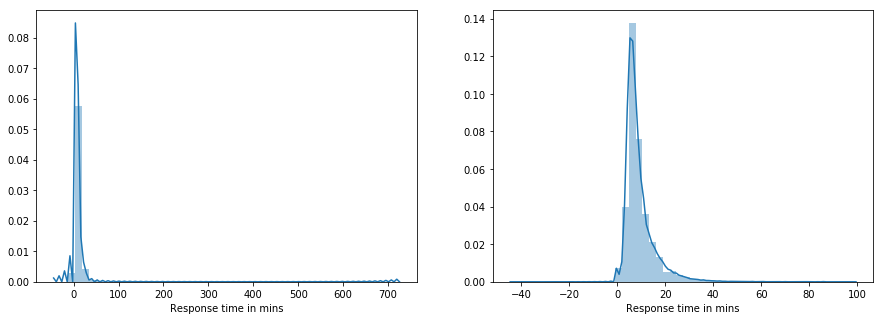

('total number of data points = ', 72661)
('total data points being included = ', 58466)


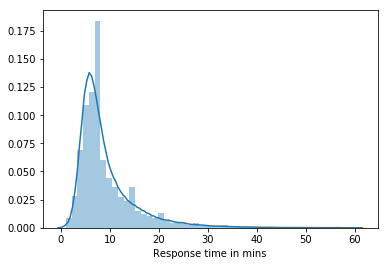

+-------+-----------------+
|summary|    response_time|
+-------+-----------------+
|  count|            58466|
|   mean|9.212773235726747|
| stddev|6.118962484696464|
|    min|              1.0|
|    max|             60.0|
+-------+-----------------+



In [9]:
fig = plt.figure(figsize= (15,5))

plt.subplot(1, 2, 1)
sns.distplot(df1.filter(df1['response_time'] <> 0 ).select('response_time').collect())
plt.xlabel('Response time in mins')

plt.subplot(1, 2, 2)
sns.distplot(df1.filter(df1['response_time'] < 100 ).select('response_time').collect())
plt.xlabel('Response time in mins')

plt.show()

print('total number of data points = ', df1.count())
print('total data points being included = ', df1.filter(df1['response_time'] > 0 )\
      .filter(df1['response_time'] <= 60 ).count())

sns.distplot(df1.filter(df1['response_time'] > 0 ).filter(df1['response_time'] <= 60 ).select('response_time').collect())
plt.xlabel('Response time in mins')
plt.show()

df1.filter(df1['response_time'] > 0 ).filter(df1['response_time'] <= 60 ).select('response_time').describe().show()

###### From the above plot we can safely say, response time of most of our data points lie below 60 minutes. We can drop all the points where we don't have response time or response time is negative or response time is more than 1 hour.

In [10]:
df1 = df1.filter(df1['response_time'] > 0 ).filter(df1['response_time'] <= 60 )
df1.limit(5).toPandas()

,Unit_ID,Incident_Number,Call_Type,Received_DtTm,On_Scene_DtTm,Available_DtTm,Zipcode_of_Incident,Station_Area,Box,Original_Priority,Call_Type_Group,Number_of_Alarms,Unit_Type,Fire_Prevention_District,Supervisor_District,Location,RowID,Received_month,Received_Hour,response_time
0,76,19001062,Medical Incident,2019-01-03 12:03:00,2019-01-03 12:08:00,2019-01-03 13:15:00,94109.0,3.0,1557.0,3,Potentially Life-Threatening,1,MEDIC,4,3,"(37.788126303439334, -122.41765721404082)",190031501-76,1,12,5.0
1,E05,18150772,Medical Incident,2018-12-25 13:30:00,2018-12-25 13:34:00,2018-12-25 13:36:00,94103.0,6.0,5251.0,A,Potentially Life-Threatening,1,ENGINE,2,8,"(37.76842297041315, -122.42659038550269)",183591352-E05,12,13,4.0
2,58,18138664,Traffic Collision,2018-11-26 17:34:00,2018-11-26 17:40:00,2018-11-26 18:07:00,94103.0,29.0,2331.0,3,Potentially Life-Threatening,1,MEDIC,2,6,"(37.77004977231887, -122.40700149157576)",183302942-58,11,17,6.0
3,70,18132759,Medical Incident,2018-11-12 15:48:00,2018-11-12 16:03:00,2018-11-12 17:34:00,94121.0,34.0,7312.0,3,Non Life-threatening,1,MEDIC,7,1,"(37.77419656897696, -122.51003379090652)",183162414-70,11,15,15.0
4,55,18150285,Medical Incident,2018-12-24 06:44:00,2018-12-24 06:52:00,2018-12-24 07:29:00,94103.0,36.0,5125.0,E,Potentially Life-Threatening,1,MEDIC,2,6,"(37.770913337297436, -122.42030499432543)",183580435-55,12,6,8.0


In [11]:
df1.registerTempTable('temptable')

df2 = sqlContext.sql("\
SELECT \
    A.RowID as temp_rowid,\
    SUM(B.response_time)/COUNT(B.response_time) AS avg_response_history \
FROM \
    temptable A JOIN temptable B ON A.Unit_ID = B.Unit_ID \
WHERE \
     (B.Received_DtTm >= A.Received_DtTm - INTERVAL 1 DAY) and (B.Received_DtTm < A.Received_DtTm) \
GROUP BY A.RowID\
")

df1 = df1.join(df2, df1.RowID == df2.temp_rowid, 'outer')
df1 = df1.drop('temp_rowid')

df1.limit(5).toPandas()

,Unit_ID,Incident_Number,Call_Type,Received_DtTm,On_Scene_DtTm,Available_DtTm,Zipcode_of_Incident,Station_Area,Box,Original_Priority,Call_Type_Group,Number_of_Alarms,Unit_Type,Fire_Prevention_District,Supervisor_District,Location,RowID,Received_month,Received_Hour,response_time,avg_response_history
0,86,18127873,Medical Incident,2018-11-01 12:23:00,2018-11-01 12:31:00,2018-11-01 13:44:00,94118.0,10.0,7114.0,3,Potentially Life-Threatening,1,MEDIC,7,1,"(37.78443958806357, -122.45915822168865)",183051938-86,11,12,8.0,10.666667
1,50,18127908,Medical Incident,2018-11-01 13:49:00,2018-11-01 13:53:00,2018-11-01 14:30:00,94103.0,1.0,2251.0,A,Non Life-threatening,1,MEDIC,3,6,"(37.78013037449471, -122.40987144993309)",183052328-50,11,13,4.0,4.000000
2,RA48,18127935,Medical Incident,2018-11-01 14:47:00,2018-11-01 14:54:00,2018-11-01 15:36:00,94130.0,48.0,2931.0,2,Potentially Life-Threatening,1,MEDIC,None,6,"(37.82481904268439, -122.37503044221887)",183052600-RA48,11,14,7.0,6.000000
3,RC1,18127985,Medical Incident,2018-11-01 17:00:00,2018-11-01 17:15:00,2018-11-01 17:53:00,94105.0,1.0,2157.0,3,Potentially Life-Threatening,1,RESCUE CAPTAIN,3,6,"(37.78701078768754, -122.39997496189893)",183053166-RC1,11,17,15.0,8.500000
4,RC1,18128080,Medical Incident,2018-11-01 21:07:00,2018-11-01 21:13:00,2018-11-01 21:13:00,94102.0,1.0,1454.0,A,Potentially Life-Threatening,1,RESCUE CAPTAIN,3,6,"(37.782230575644824, -122.41029202677699)",183054088-RC1,11,21,6.0,9.375000


In [12]:
# save the file for model fitting
df1.write.parquet('/home/shashank/Documents/gitWorkspace/SFFD-Spark-Project/Data/FireCleaned.parquet')